In [2]:
# Imports and utils

import os
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

import sys
sys.path.append('../../')
sys.path.append('../../..')
sys.path.append('')

sys.path.append('/home/yau/sequencing_the_neuron/reconstruction/uti')

from mdistiller.models import cifar_model_dict, imagenet_model_dict
from mdistiller.distillers import distiller_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint, log_msg
from mdistiller.engine.cfg import CFG as cfg
from mdistiller.engine.cfg import show_cfg

# get cifar100 class list
from mdistiller.dataset.cifar100 import get_data_folder
import torchvision.datasets as datasets

class_names = datasets.CIFAR100(root=get_data_folder(), train=False, download=True).classes

In [3]:
# Loading LDA checkpoint

def load_LDA(cfg_path, checkpoint):
    cfg.merge_from_file(cfg_path)
    cfg.freeze()
    log_msg(show_cfg(cfg))
    num_classes = 100
    
    model_student = cifar_model_dict[cfg.DISTILLER.STUDENT][0](
        num_classes=num_classes
    )
    
    net, pretrain_model_path = cifar_model_dict[cfg.DISTILLER.TEACHER]
    assert (
        pretrain_model_path is not None
    ), "no pretrain model for teacher {}".format(cfg.DISTILLER.TEACHER)
    model_teacher = net(num_classes=num_classes)

    distiller = distiller_dict[cfg.DISTILLER.TYPE](model_student, model_teacher, cfg)
    distiller = nn.DataParallel(distiller)
    distiller.load_state_dict(load_checkpoint(checkpoint)["model"])
    return distiller, cfg

In [4]:
ckpt = "/workspace/disagreement_augmentation_v2/output/latent_da/resnet32x4_resnet8x4_LDA_10_1_3/best"

cfg_path = "/workspace/disagreement_augmentation_v2/configs/cifar100/lda/viz/10_epoch.yaml"


distiller, cfg = load_LDA(cfg_path, ckpt)

train_loader, val_loader, num_data, num_classes = get_dataset(cfg)



[INFO] CONFIG:
DATASET:
  NUM_WORKERS: 2
  SUBSET: null
  TEST:
    BATCH_SIZE: 64
  TYPE: cifar100
DISTILLER:
  STUDENT: resnet8x4
  TEACHER: resnet32x4
  TYPE: LDA
EXPERIMENT:
  DA: true
  NAME: resnet32x4_resnet8x4_LDA_1
  PROJECT: latent_da
  TAG: lda,resnet32x4,resnet8x4, 0.1
LOG:
  PREFIX: ./output
  SAVE_CHECKPOINT_FREQ: 40
  TENSORBOARD_FREQ: 500
  WANDB: true
SOLVER:
  BATCH_SIZE: 64
  DOT:
    DELTA: 0.075
  EPOCHS: 240
  LR: 0.05
  LR_DECAY_RATE: 0.1
  LR_DECAY_STAGES:
  - 150
  - 180
  - 210
  MOMENTUM: 0.9
  TRAINER: base
  TYPE: SGD
  WEIGHT_DECAY: 0.0005



In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [6]:
distiller.module.cfg.DA.EPOCHS

0

In [7]:
def LDA(images, distiller, epochs, lr=0.1):
        """Latent Disagreement Augmentation"""
        device = images.device
        image = images.clone()
            
        try:
            # Process the image through the encoder to get latent
            with torch.no_grad():
                denormalized_image = distiller.denormalize(image)
                # Resize to fit encoder input size
                resized_image = F.interpolate(denormalized_image, size=(256, 256), mode='bilinear', align_corners=False)
                latent = distiller.ae.encoder(resized_image)
            
            # Create a fresh tensor with gradients
            latent = latent.detach().clone().to(device).requires_grad_(True)
            
            # Create optimizer for the latent
            optimizer = torch.optim.Adam([latent], lr=float(lr))
            
            # Store model modes and set to eval during optimization
            student_training = distiller.student.training
            teacher_training = distiller.teacher.training
            distiller.student.eval()
            distiller.teacher.eval()
            
            # Optimization loop for latent
            for i in range(int(epochs)):
                optimizer.zero_grad()
                
                # Forward through decoder (with gradient)
                decoded_image = distiller.ae.decoder(latent)
                decoded_image = torch.clamp(decoded_image, 0, 1)
                normalized_image = distiller.norm(decoded_image)
                resized_image = F.interpolate(normalized_image, size=(32, 32), mode='bilinear', align_corners=False)
                
                # Get model predictions
                
                logits_student, _ = distiller.student(resized_image)
                logits_teacher, _ = distiller.teacher(resized_image)
                
                # Calculate loss on detached logits (focusing gradient on latent only)
                normalized_student = F.normalize(logits_student, p=1, dim=1)
                normalized_teacher = F.normalize(logits_teacher, p=1, dim=1)
                
                # Maximize disagreement
                disagreement_loss = -1.0 * F.mse_loss(normalized_student, normalized_teacher)
                
                # Create a dummy variable with gradient that depends on the latent
                # This ensures we have a proper gradient path
                dummy_loss = torch.sum(resized_image * 0.0)
                
                # Total loss combines the disagreement with the dummy connection
                total_loss = disagreement_loss # + dummy_loss
                
                # Backward pass and optimization step
                total_loss.backward()
                optimizer.step()
            
            # Reset models to their original training modes
            if student_training:
                distiller.student.train()
            if teacher_training:
                distiller.teacher.train()
            
            # Generate the final augmented image
            with torch.no_grad():
                decoded_image = distiller.ae.decoder(latent)
                decoded_image = torch.clamp(decoded_image, 0, 1)
                normalized_image = distiller.norm(decoded_image)
                augmented_image = F.interpolate(normalized_image, size=(32, 32), mode='bilinear', align_corners=False)
                
                result = augmented_image
                    
            return result.detach()
            
        except Exception as e:
            print(f"Detailed DA error: {type(e).__name__}: {e}")
            # Return original images on error
            return images

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]


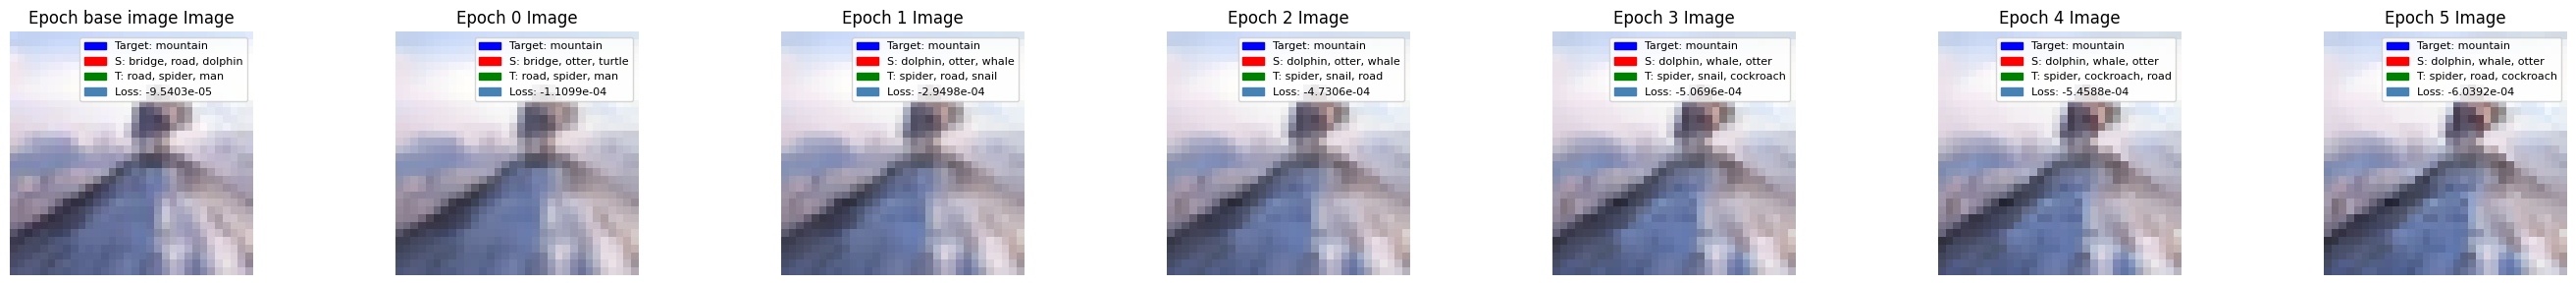

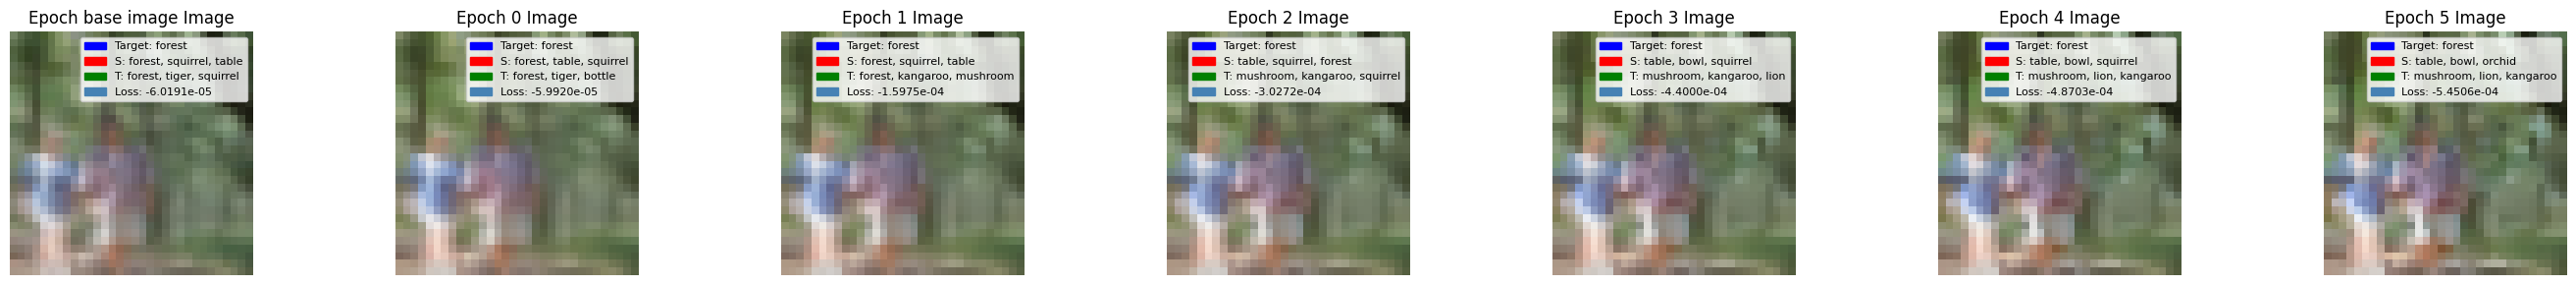

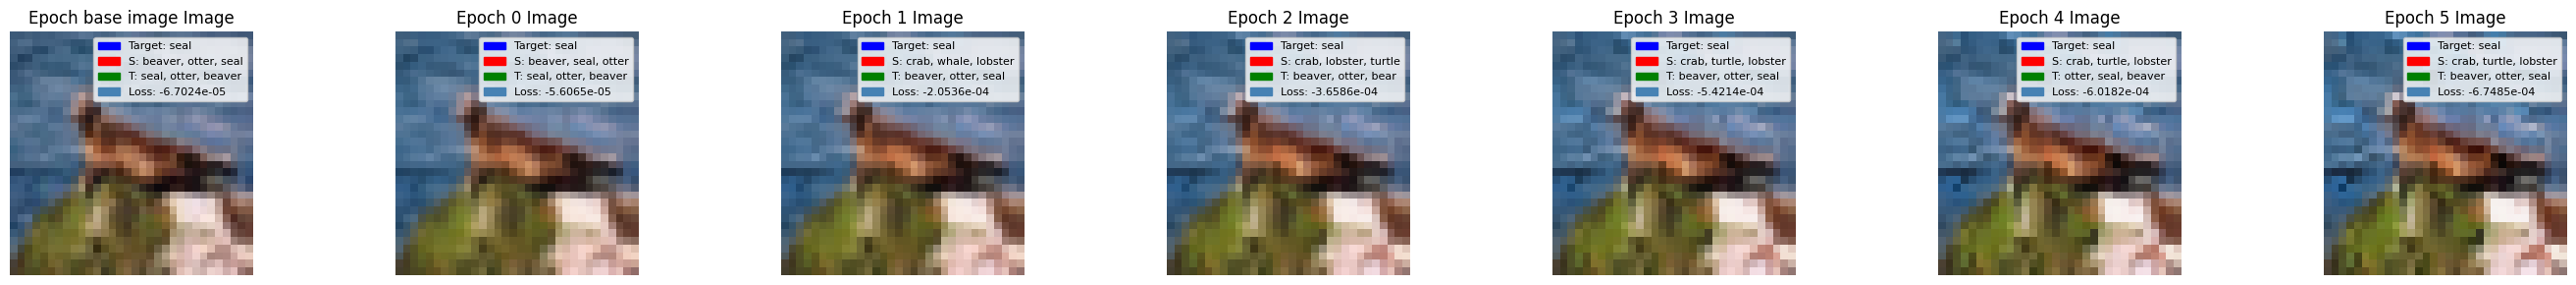

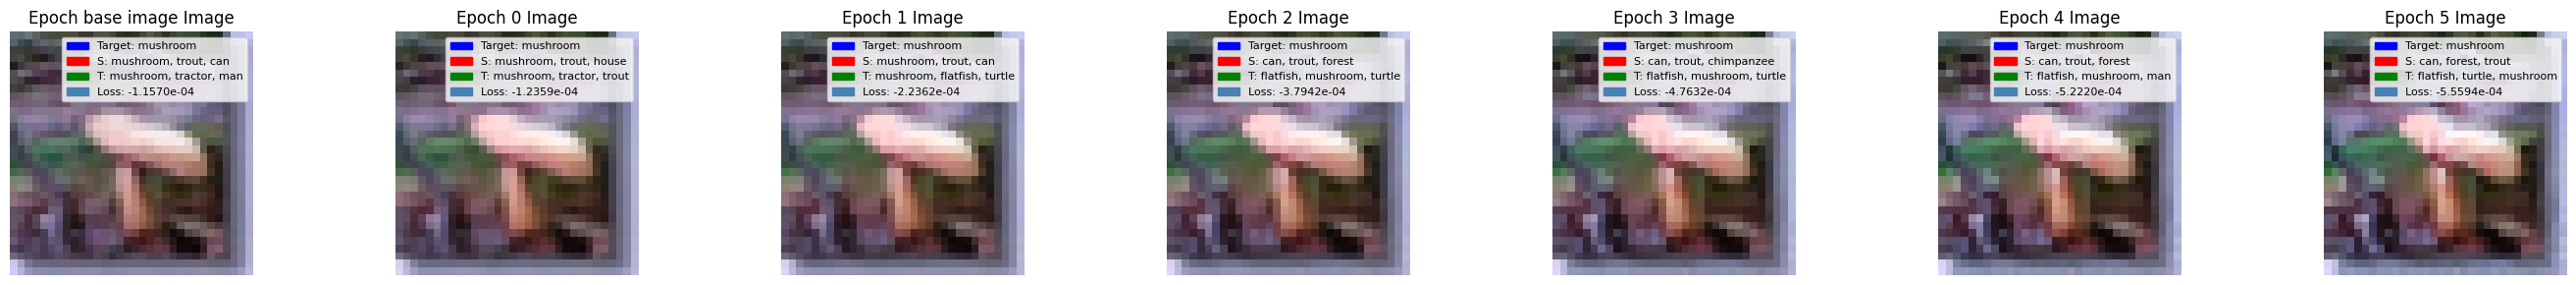

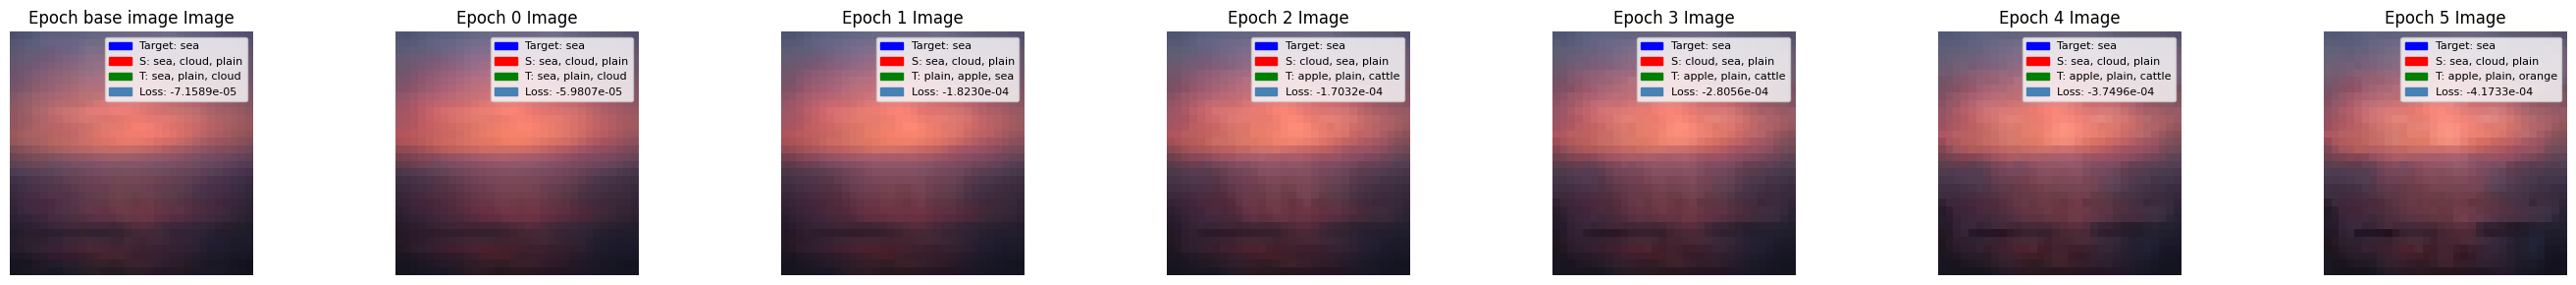

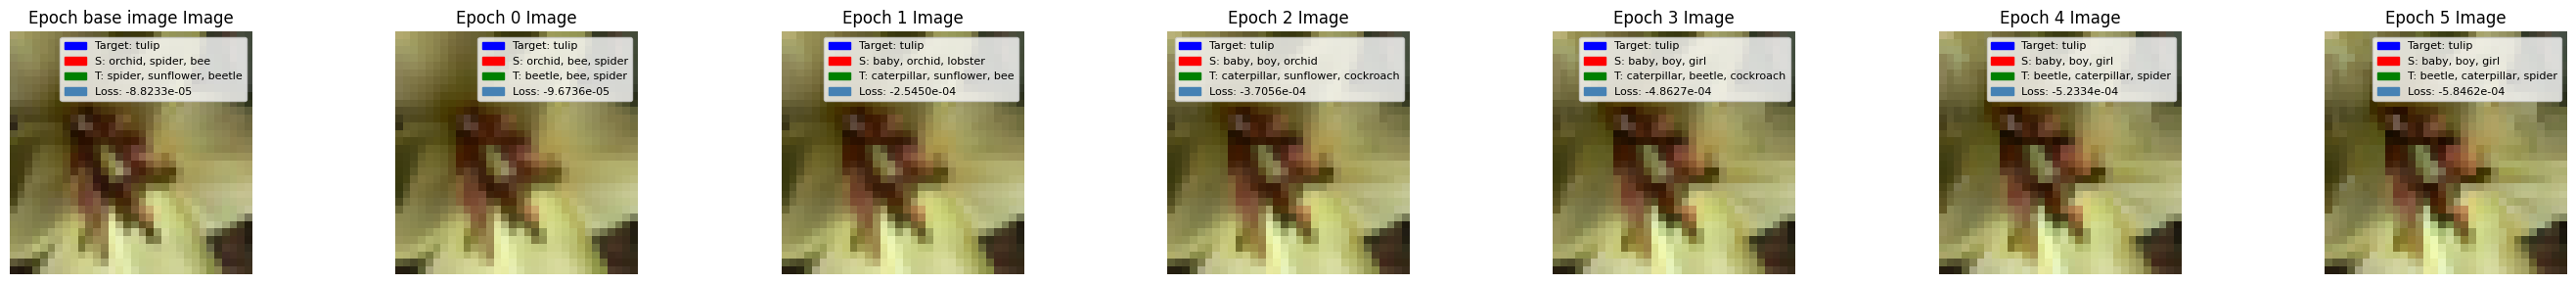

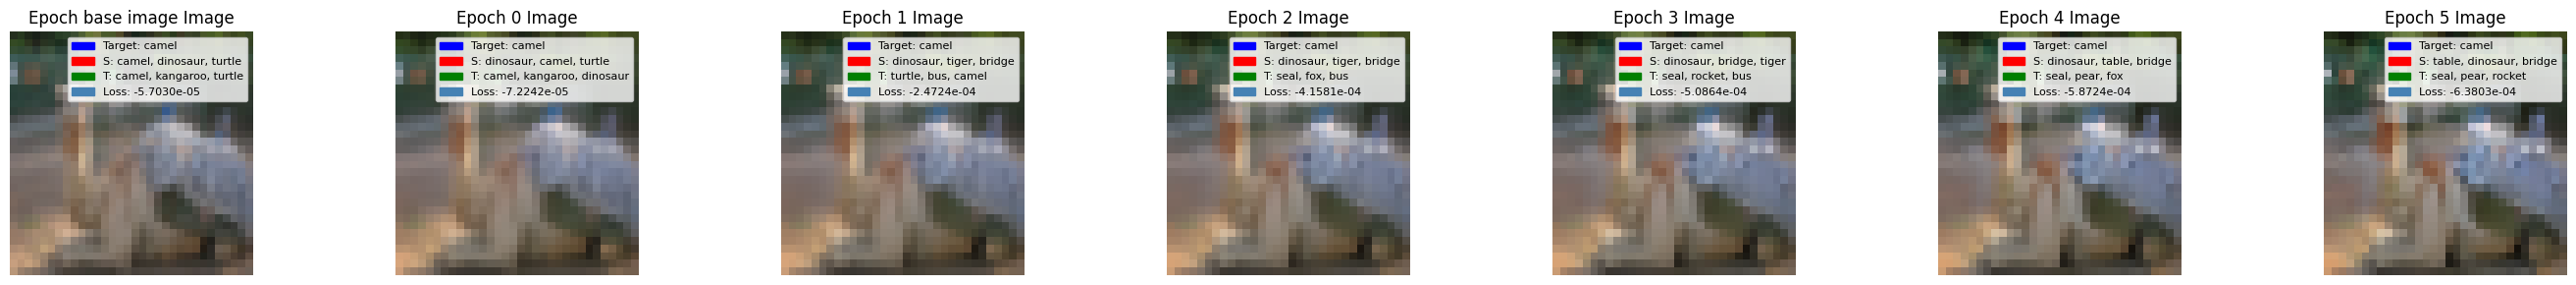

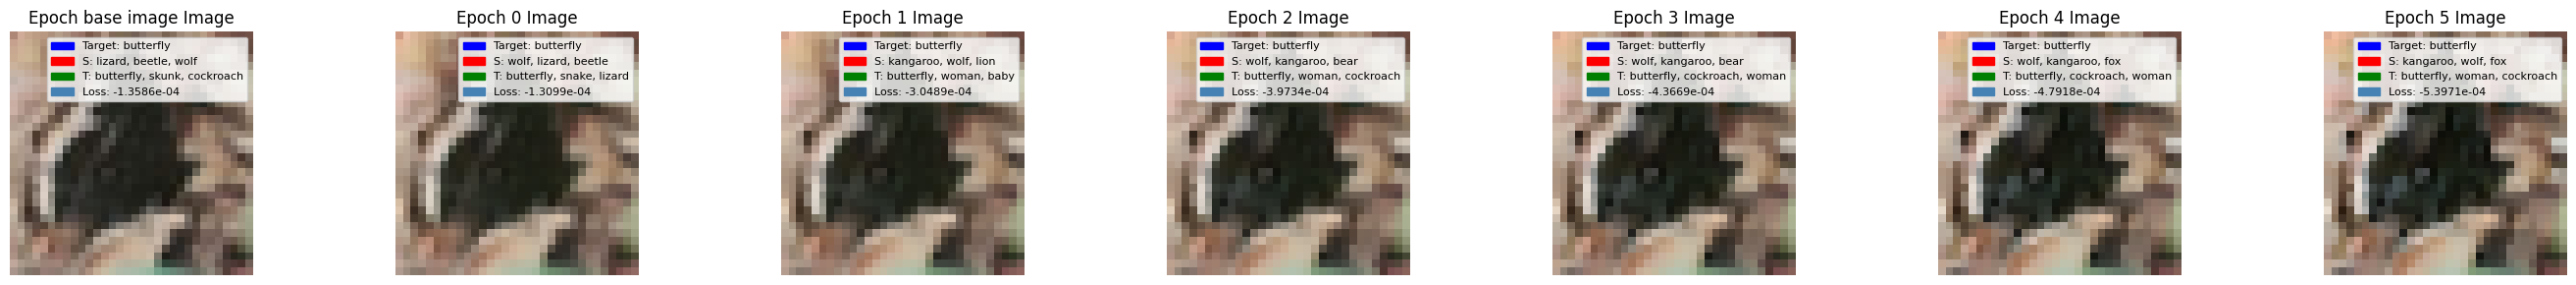

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from torchvision import datasets

# CIFAR-100 class index → label
id2label = datasets.CIFAR100(root=get_data_folder(), train=False, download=True).classes

def plot_row(images, epochs, annotations):
    """
    Plots a row of N images side-by-side, with titles "Epoch {epochs[i]} Image"
    and per-image legends from annotations[i].
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 3))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"Epoch {epochs[i]} Image")
        ax.axis('off')
        if annotations[i]:
            ax.legend(handles=annotations[i], loc='upper right', fontsize=8)
    plt.tight_layout()
    return fig

# —— USER CONFIGURABLE: list of epochs (in training steps) you want to visualize ——
# You can put [10, 50, 100] or any other list of integers here.
lda_steps = epochs = [0, 1, 2, 3, 4, 5]

print(lda_steps)
print(epochs)

# —— end user config ——

for before, target in val_loader:
    before = before.cuda()
    target = target.cpu()

    # 1) generate all “after” images
    images = [before]
    for steps in lda_steps:
        images.append(LDA(before, distiller.module, steps))

    # 2) get student & teacher logits on each image
    student_logits = [
        distiller.module.student(x)[0].cpu() for x in images
    ]
    teacher_logits = [
        distiller.module.teacher(x)[0].cpu() for x in images
    ]

    # 3) compute disagreement losses
    loss_vals = []
    for s_log, t_log in zip(student_logits, teacher_logits):
        norm_s = F.normalize(s_log, p=1, dim=1)
        norm_t = F.normalize(t_log, p=1, dim=1)
        # negative MSE of L1‑normalized logits
        loss_vals.append(
            -1.0 * F.mse_loss(norm_s, norm_t, reduction='none').mean(dim=1)
        )

    # 4) denormalize images for display
    images = [distiller.module.denormalize(x).cpu() for x in images]

    # 5) plot the first 8 samples
    for i in range(8):
        # build top‑3 predictions & annotations per image
        annotations = []
        for j, (s_log, t_log) in enumerate(zip(student_logits, teacher_logits)):
            student_top3 = torch.topk(s_log[i], 3).indices.tolist()
            teacher_top3 = torch.topk(t_log[i], 3).indices.tolist()
            preds = [id2label[c] for c in student_top3]
            tops = [id2label[c] for c in teacher_top3]
            target_lbl = id2label[target[i].item()]
            loss_ij = loss_vals[j][i].item()
            annotations.append([
                Patch(color='blue',   label=f"Target: {target_lbl}"),
                Patch(color='red',    label=f"S: {', '.join(preds)}"),
                Patch(color='green',  label=f"T: {', '.join(tops)}"),
                Patch(color='steelblue', label=f"Loss: {loss_ij:.4e}")
            ])

        fig = plot_row(
            [img[i] for img in images],
            ["base image"] + epochs,
            annotations
        )
        plt.show()

    break  # only first batch
